In [2]:
# default_exp data.load_pd

In [3]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [5]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [6]:
# export
import numpy as np
import pandas as pd

In [7]:
class TSeries(TensorBase):pass

In [8]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [9]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = L(self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)]))
        labels = L(self._meta.get('label',['x']*len(arrays)))
        assert len(m)==len(labels)==len(arrays)
        t = np.arange(array.shape[1])        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)
        ctx.legend()
        return ctx
class TensorSeqsX(TensorSeqs):pass

In [10]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

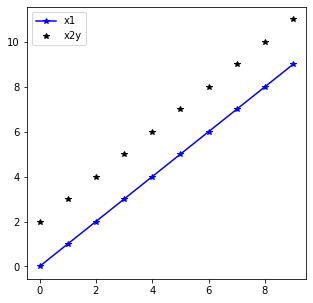

In [11]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

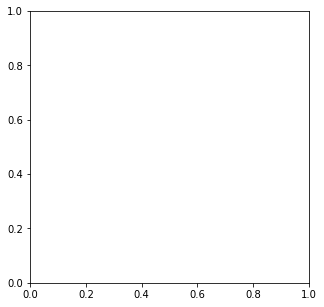

In [12]:
# hide
test_fail(TensorSeqs(torch.randn(2,10), m='b', label = ['x1','y2']).show)

In [13]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self)}")
        return ax
    
class TensorCat(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','cat')}: {str(self)}")
        return ax

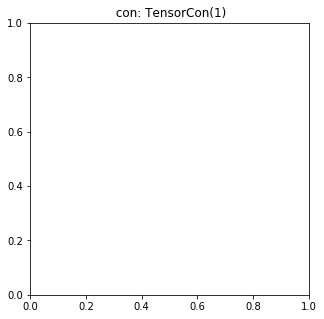

In [14]:
TensorCon(1).show()

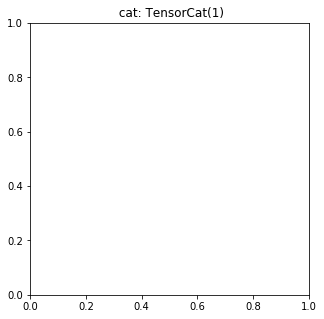

In [15]:
TensorCat(1).show()

## Utils

In [16]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [17]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [18]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [19]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [20]:
# export

from fastai2.vision.data import get_grid
from fastseq.core import *
def _show_metatuple(t, ax):
    for o in t:
        ax = o.show(ctx = ax)
    return ax

def get_ax(ax, ctx, figsize, **kwargs):
    ax = ifnone(ax,ctx)
    if ax is None:
        _, ax = plt.subplots(figsize=figsize, **kwargs)
    return ax

@delegates(plt.subplots)
def show_mt(self, ax = None, ctx=None, figsize = (10,10), **kwargs):
    ax = get_ax(ax, ctx, figsize, **kwargs)
    return _show_metatuple(self, ax)   
MetaTuple.show = show_mt

In [21]:
show_doc(MetaTuple.show,name='MetaTuple.show')

<h4 id="MetaTuple.show" class="doc_header"><code>MetaTuple.show</code><a href="__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>MetaTuple.show</code>(**`ax`**=*`None`*, **`ctx`**=*`None`*, **`figsize`**=*`(10, 10)`*, **`nrows`**=*`1`*, **`ncols`**=*`1`*, **`sharex`**=*`False`*, **`sharey`**=*`False`*, **`squeeze`**=*`True`*, **`subplot_kw`**=*`None`*, **`gridspec_kw`**=*`None`*)



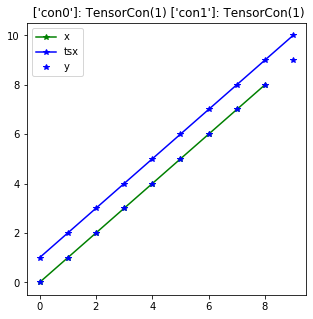

In [22]:
x,xts,a,b = TensorSeqs(np.arange(9)[None,:],label=['x'],m=['g']),TensorSeqs(np.arange(1,11)[None,:],label=['tsx']), TensorCon(1,label=['con0']),TensorCon(1, label=['con1'], m='r')
y = TensorSeqs(np.arange(10)[None,:],label=['y'])
MetaTuple(x,xts,a,b,y).show(figsize = (5,5))

# Dataloader

In [23]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqsX(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)     
        return MetaTuple(r)
        
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [31]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -0.318652 1 1.635482 2 2.091249 3 3.086027 4 4.551341 5 6.711597 6 6.487499 7 8.660704 8 8.213588 9 9.605522 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.923785 1 1.236187 2 3.996760 3 3.478574 4 6.391093 5 6.377595 6 7.134646 7 8.052351 8 9.029605 9 10.842611 10 11.248252 11 12.070102 dtype: float64,1.0,1


In [32]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [40]:
for o in dl:
    test_eq(type(o), MetaTuple)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), MetaTuple)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break

In [42]:
# hide
# without cat or con
horizon,lookback = 3,5
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), MetaTuple)
    test_eq(len(o),3)
    dct = {k:v for k,v in zip(['x','tsx','y'], o)}
    test_eq(type(o), MetaTuple)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [43]:
# hide
# test self.new
dl.new()

# Showing

In [44]:
# export
@typedispatch
def show_batch(x:MetaTuple, y, samples, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = MetaTuple([type(o)(o[i],**o._meta) for o in x])
        ctx = o.show(ctx=ctx)
    return ctxs


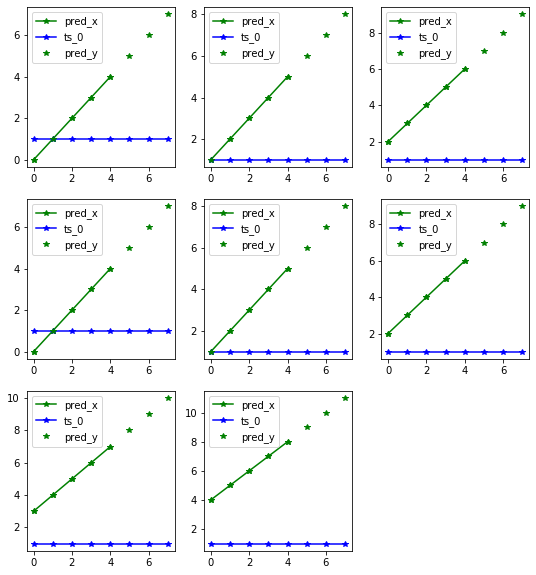

In [49]:
dl.show_batch()

# Intergration Example

In [50]:
from fastseq.data.external import *

In [51]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-0.9246980216026273, -1.0752066079133622, -1.0343056197638065, -1.0205988706606473, -1.1055610430062064, -1.5715298220026908, -1.1440710047534597, -0.7710556545854237, 0.2053606728518615, 0.8244034694119999, 0.7962946465466717, 0.5541089586093493, 0.440757216511369, 0.40148092734723007, 0.11249887116020817, -0.04766064938046282, -0.3543447126315359, -0.8749602473177543, -0.7541718961048118, -0.563836636146175, -0.3581810471337999, -0.6200476202326833, -0.7691707421406279, -0.4762493084199114, 0.14164809981294765, 0.7402752846728816, 0.8403338493341285, 0.7188950980418847, 1.2971133038150...","[[9.488364195521282, 9.224063182518055, 9.669038691207973, 10.210800215746719, 9.557513892717834, 7.779222489479095, 6.641769412819092, 7.509539135260811, 9.509949329934702, 10.480094689811772, 9.56810531673473, 8.150789069324528, 7.961956842013028, 8.98059584836727, 9.787649815339192, 9.658860254581608, 9.488364195521282, 9.224063182518055, 9.669038691207973, 10.210800215746719, 9.557513892717834, 7.779222489479095, 6.641769412819092, 7.509539135260811, 9.509949329934702, 10.480094689811772, 9.56810531673473, 8.150789069324528, 7.961956842013028, 8.98059584836727, 9.787649815339192, 9.658...",0,0.635884
1,"[[-0.04822680224041208, -0.13348036661225252, -0.3682407646917218, 0.026431833567540072, 0.1667126811698946, 0.7440787501707395, 1.3808414405005074, 0.8821682180428275, 0.953507631793307, 0.13468969169968809, 0.07125375764771648, -0.8377224631295471, -2.2833307843284474, -1.9517956889390673, -0.910140213889415, 0.15769681493616855, 0.672845691724756, 0.7163901065855027, 1.898825936029667, 1.4867005447513484, 0.9141653633666657, 0.2939985857679737, -0.4267655457567702, -1.2433179006193285, -1.7261629591098209, -0.8196098310625248, -1.4602513463949578, -0.392573069617816, -0.0076288047898670...","[[2.323439505836798, 2.0661363596237594, 1.5157714611933137, 1.5617152119619933, 2.2770719246468345, 2.8703038640229503, 2.7917498934267506, 2.4575029238883124, 2.6139197406492185, 3.261000343709466, 3.652387947827471, 3.371989641973175, 2.9694665628101182, 3.236356445563257, 4.0995549775155125, 4.66969175725035, 2.323439505836798, 2.0661363596237594, 1.5157714611933137, 1.5617152119619933, 2.2770719246468345, 2.8703038640229503, 2.7917498934267506, 2.4575029238883124, 2.6139197406492185, 3.261000343709466, 3.652387947827471, 3.371989641973175, 2.9694665628101182, 3.236356445563257, 4.0995...",0,-0.033392
2,"[[1.3503078124957215, 1.147497112133372, 0.7734774487557254, 0.392867503563145, 0.13469844192261352, 0.14308609078700035, 0.27706708258055585, 0.835684903188621, 1.0863338524686261, 1.555322091742307, 1.99859787259578, 1.5463762284711653, 1.251825009152474, 0.9016867820158502, 0.0775806018689578, -0.5752559680415648, -1.1487109391768642, -1.1718387487358213, -1.2406514458227347, -1.0276274068663263, -0.9454256235849241, -0.9425062856701787, -0.955980765154993, -1.2182674488399077, -1.3371938619933774, -1.20900360672971, -1.0320641904280834, -0.7400205259794581, -0.361703159527547, -0.05507...","[[4.571913085956133, 4.386288830296616, 4.114758424225355, 4.049107364590651, 4.191574093519243, 4.254462951437013, 4.060837766743254, 3.792013764629984, 3.7393084801142584, 3.902721913196075, 3.9909365288583767, 3.8226371019091574, 3.574759803949104, 3.5350002945523578, 3.7011201315921647, 3.781333818220225, 4.571913085956133, 4.386288830296616, 4.114758424225355, 4.049107364590651, 4.191574093519243, 4.254462951437013, 4.060837766743254, 3.792013764629984, 3.7393084801142584, 3.902721913196075, 3.9909365288583767, 3.8226371019091574, 3.574759803949104, 3.5350002945523578, 3.7011201315921...",0,0.551640
3,"[[-0.2928497408504602, -0.6369912217488144, -0.7590163066093649, -0.27855627284062384, 0.08784250290488975, 0.86827339098427, 1.0207905048414811, 1.075592779753451, 0.4705119417873973, -0.18333000707191188, -1.175698615368745, -1.9594236122331354, -2.133783298269791, -2.054054392021999, -1.8378131392214117, -1.112902377576

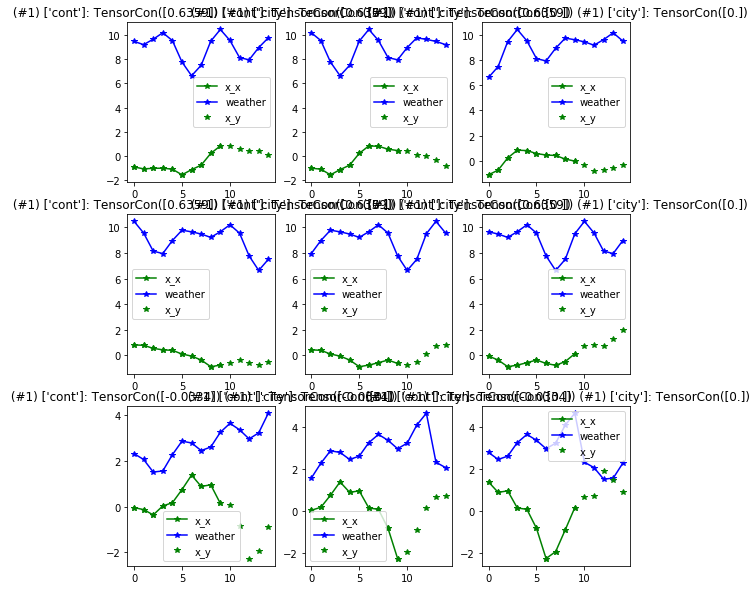

In [52]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

In [53]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
